# Sonic Porosity Log: Predicting DTS and DTC 
## Using Wavelet Transforms and ML 
Sonic Log also called porosity logs are sets of data collected and used by geophyicists to evalute the rock layer properties of well bores.  Sound waves are generated transverse/ compressiona and shearwave in the bore hole or adjecent too and the returning sound is collected.  The delta T ( of time of fight) and wave type can reveal information about the resevoir and rock layers.  This information is vital to maximize the cost and efficiency and production in the oil and gas industry drilling operations.   This project will attempt to show that the shearwave DTS and compressional wave DTC  data which is often missing parts or not collected, yet very vital, can be predicted given other features in the logs. 

### Wavelet transform and XGBoost Regression used for predictions

## Data is taken from Synthethic Sonic Log Curves Generation Contest 

#### Description fo the data:
- CAL - Caliper, unit in Inch,
- CNC - Neutron, unit in dec
- GR - Gamma Ray, unit in API
- HRD - Deep Resisitivity, unit in Ohm per meter,
- HRM - Medium Resistivity, unit in Ohm per meter,
- PE - Photo-electric Factor, unit in Barn,
- ZDEN - Density, unit in Gram per cubit meter,
- DTC - Compressional Travel-time, unit in nanosecond per foot,
- DTS - Shear Travel-time, unit in nanosecond per foot,

In [4]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,r2_score

import xgboost as xgb

In [6]:
# Load in the train and test data sets from GitHub 
urltr = 'https://raw.githubusercontent.com/LadyKate7390/Kate_G_DS_Portfolio/refs/heads/main/Sonic%20Wave%20Velocity/train.csv'
urltest = 'https://raw.githubusercontent.com/LadyKate7390/Kate_G_DS_Portfolio/refs/heads/main/Sonic%20Wave%20Velocity/test.csv'
url = 'https://raw.githubusercontent.com/LadyKate7390/Kate_G_DS_Portfolio/refs/heads/main/Sonic%20Wave%20Velocity/real_test_result.csv'
tr_df = pd.read_csv(urltr)
ts_df= pd.read_csv(urltest)

In [7]:
print(tr_df.shape,ts_df.shape)

(30143, 9) (11088, 7)


In [8]:
tr_df.describe()

,CAL,CNC,GR,HRD,HRM,PE,ZDEN,DTC,DTS
count,30143.000000,30143.000000,30143.000000,30143.000000,30143.000000,30143.000000,30143.000000,30143.000000,30143.000000
mean,-8.394576,-23.692615,38.959845,3.977690,1.547299,-17.446739,-20.229982,-54.891703,-9.737567
std,129.970219,157.142679,108.504554,365.112753,456.908969,149.083136,148.809506,372.858812,440.314119
min,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000
25%,8.058350,0.122800,17.248750,0.717700,0.712050,0.053100,2.226700,66.304350,118.534350
50%,8.625000,0.193600,36.821800,1.623000,1.628100,4.941500,2.432200,78.355100,137.689300
75%,9.048850,0.337150,58.346150,3.158300,3.280600,7.856650,2.551350,107.022500,182.973150
max,21.064200,3490.158200,1470.253400,10000.000000,60467.761700,28.106400,3.259700,155.980300,487.438400


In [9]:
# make a copy of train set as we clean up some data
dft = tr_df.copy()

In [10]:
# replace negative -999 values and deal with missing data (Na) 
dft.replace(['-999', -999], np.nan, inplace=True)

In [11]:
nan_counts = dft.isnull().sum()
print(nan_counts)

CAL      510
CNC      735
GR       254
HRD      385
HRM      385
PE       679
ZDEN     681
DTC     4054
DTS     4865
dtype: int64


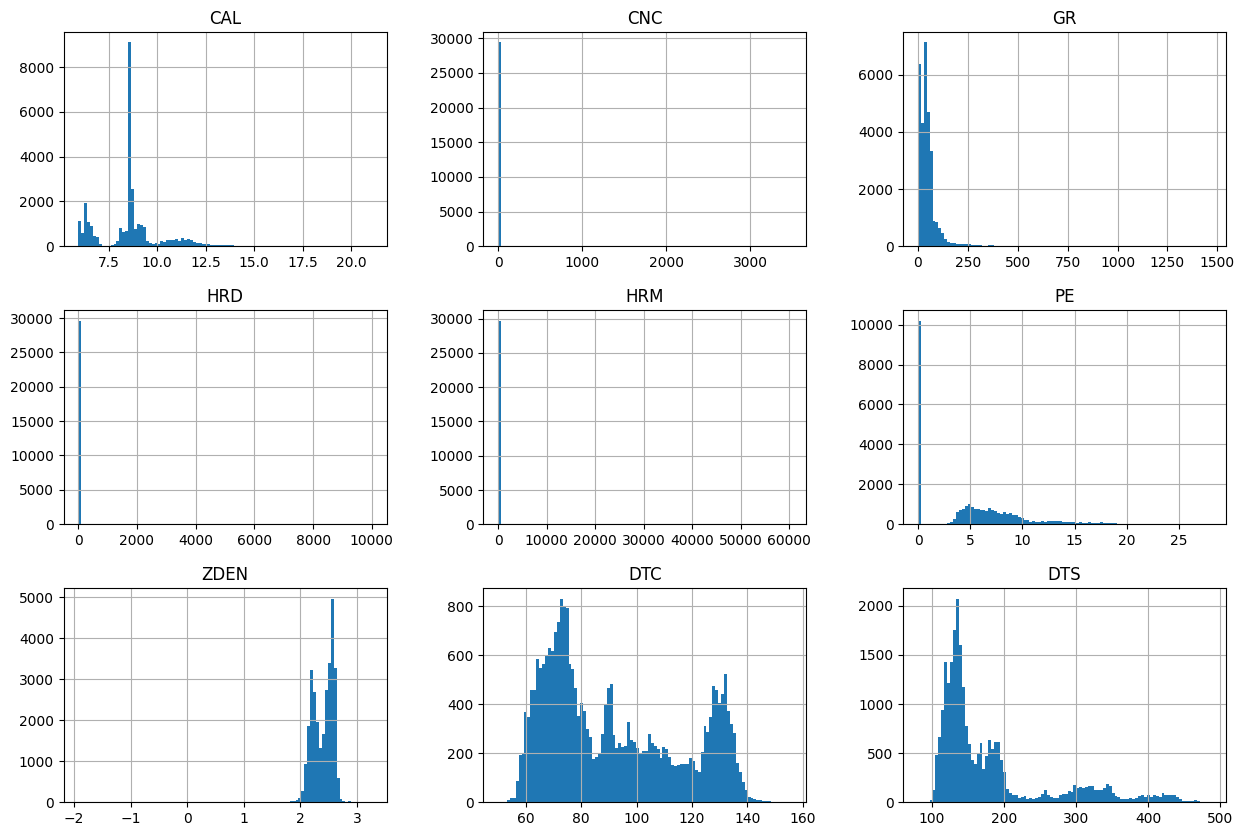

In [12]:
histdf = dft.hist(bins=100,figsize=(15,10))

array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >], dtype=object)

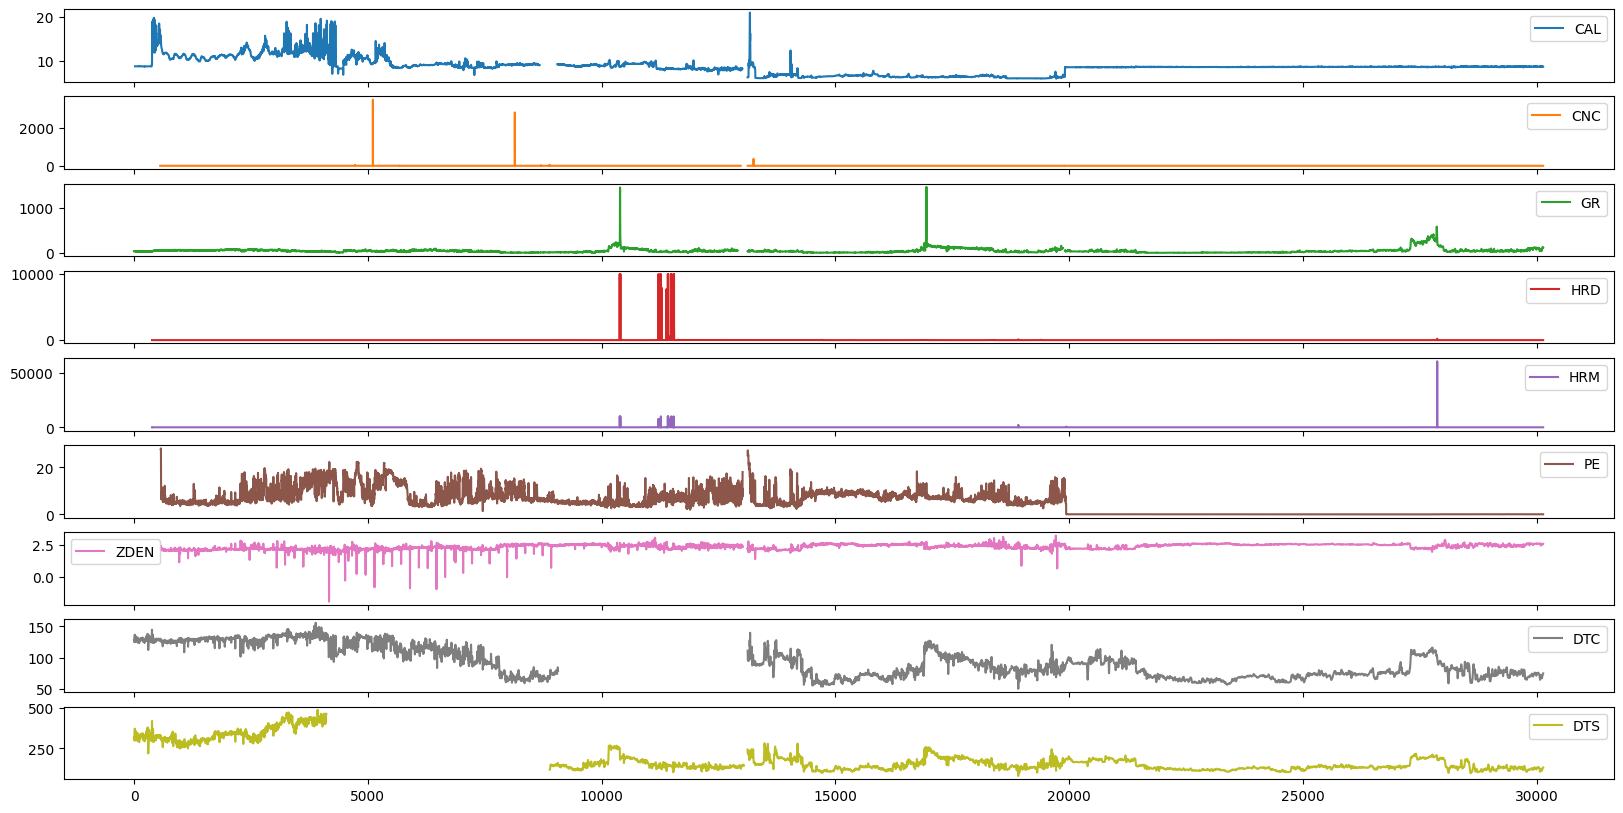

In [13]:
dft.plot(subplots=True,figsize=(20,10))

In [14]:
#Making negative values Nan of ZDEN, GR, CNC, PE. We don't want to just drop them or make them '0' for now
col = ['ZDEN', 'GR', 'CNC', 'PE']
dft[col] = dft[col].mask(dft[col] < 0)



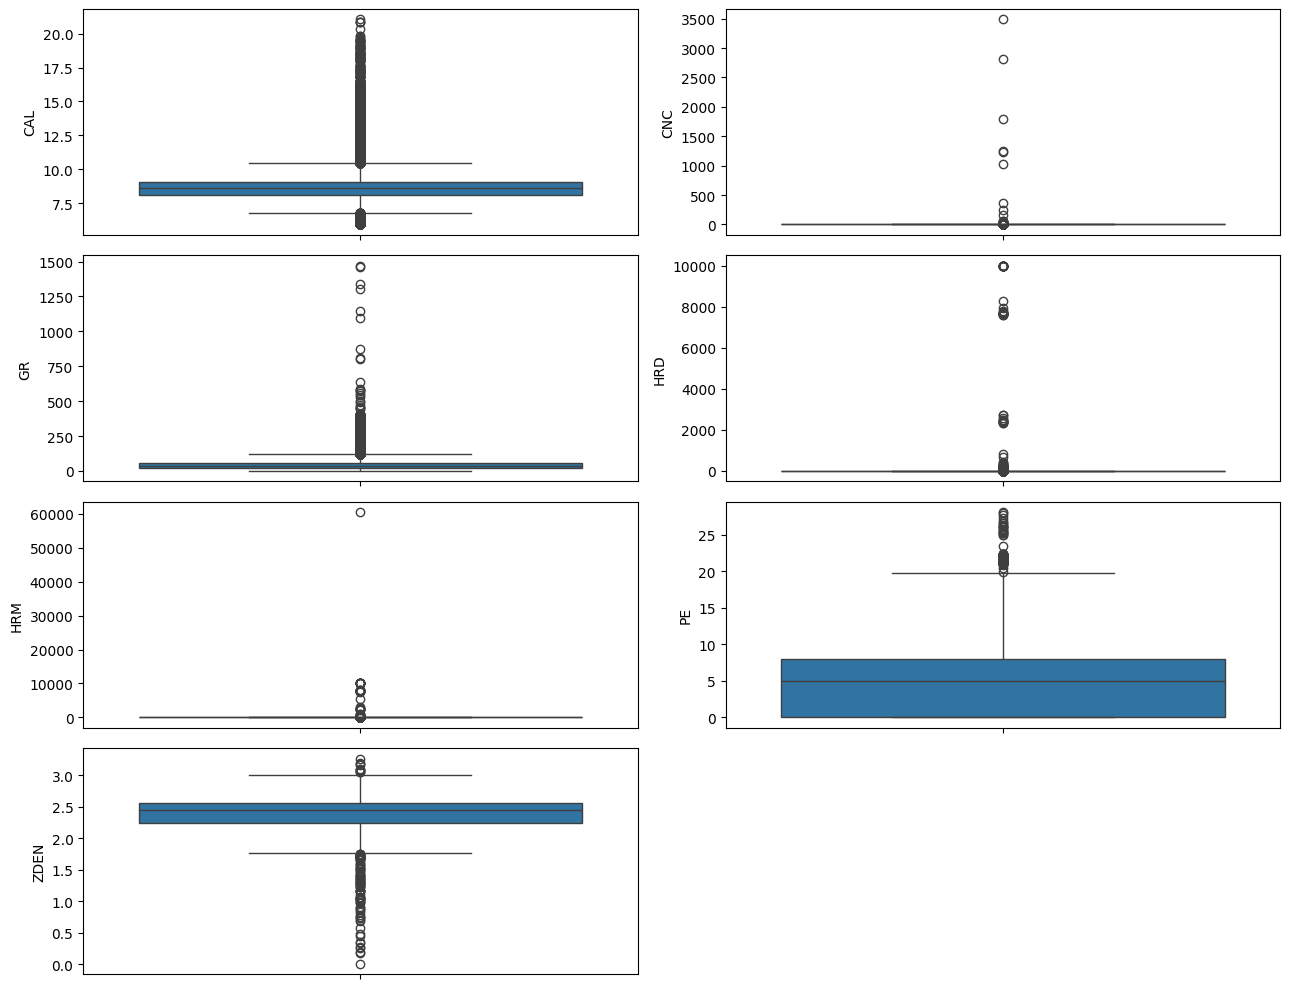

In [15]:
plt.figure(figsize=(13,10))
plt.subplot(4,2,1)
sns.boxplot(dft['CAL'])

plt.subplot(4,2,2)
sns.boxplot(dft['CNC'])

plt.subplot(4,2,3)
sns.boxplot(dft['GR'])

plt.subplot(4,2,4)
sns.boxplot(dft['HRD'])

plt.subplot(4,2,5)
sns.boxplot(dft['HRM'])

plt.subplot(4,2,6)
sns.boxplot(dft['PE'])

plt.subplot(4,2,7)
sns.boxplot(dft['ZDEN'])

plt.tight_layout()
plt.show()

In [16]:
# transforming a few variables with log function and replotting 
dft['HRM'] = dft['HRM'].apply(lambda x:np.log(x))
dft['HRD'] = dft['HRD'].apply(lambda x:np.log(x))


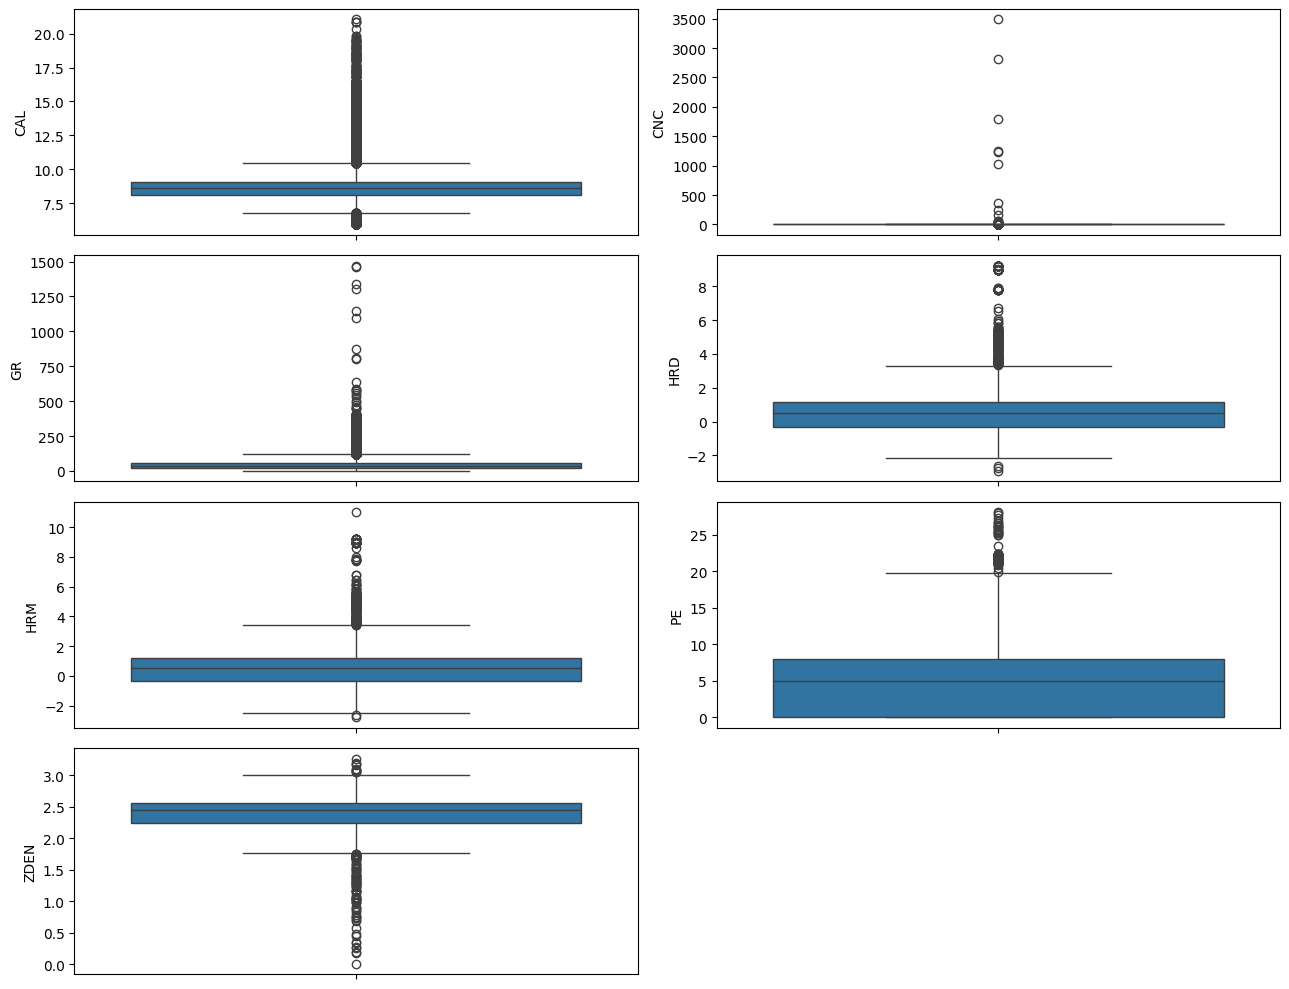

In [17]:
plt.figure(figsize=(13,10))
plt.subplot(4,2,1)
sns.boxplot(dft['CAL'])

plt.subplot(4,2,2)
sns.boxplot(dft['CNC'])

plt.subplot(4,2,3)
sns.boxplot(dft['GR'])

plt.subplot(4,2,4)
sns.boxplot(dft['HRD'])

plt.subplot(4,2,5)
sns.boxplot(dft['HRM'])

plt.subplot(4,2,6)
sns.boxplot(dft['PE'])

plt.subplot(4,2,7)
sns.boxplot(dft['ZDEN'])

plt.tight_layout()
plt.show()

In [18]:
#Looking for correlations 
dft.corr()

,CAL,CNC,GR,HRD,HRM,PE,ZDEN,DTC,DTS
CAL,1.000000,0.008630,0.020420,-0.189213,-0.158098,0.163877,-0.368183,0.585637,0.681271
CNC,0.008630,1.000000,-0.003245,-0.007311,-0.007969,0.017053,-0.008496,0.008642,0.048946
GR,0.020420,-0.003245,1.000000,-0.021496,-0.019504,-0.034032,-0.158940,0.355556,0.233183
HRD,-0.189213,-0.007311,-0.021496,1.000000,0.972225,-0.223456,0.570952,-0.608361,-0.407105
HRM,-0.158098,-0.007969,-0.019504,0.972225,1.000000,-0.260325,0.576939,-0.602069,-0.411537
PE,0.163877,0.017053,-0.034032,-0.223456,-0.260325,1.000000,-0.340607,0.477524,0.440266
ZDEN,-0.368183,-0.008496,-0.158940,0.570952,0.576939,-0.340607,1.000000,-0.756792,-0.670186
DTC,0.585637,0.008642,0.355556,-0.608361,-0.602069,0.477524,-0.756792,1.000000,0.941639
DTS,0.681271,0.048946,0.233183,-0.407105,-0.411537,0.440266,-0.670186,0.941639,1.000000


In [19]:
ts_df.corr()

,CAL,CNC,GR,HRD,HRM,PE,ZDEN
CAL,1.000000,-0.290943,0.024399,0.037764,0.050929,0.446757,0.438947
CNC,-0.290943,1.000000,0.575440,-0.247362,0.016520,-0.563464,-0.710657
GR,0.024399,0.575440,1.000000,-0.124756,0.154772,-0.121305,-0.129897
HRD,0.037764,-0.247362,-0.124756,1.000000,0.415450,-0.002108,0.077118
HRM,0.050929,0.016520,0.154772,0.415450,1.000000,0.046397,0.028714
PE,0.446757,-0.563464,-0.121305,-0.002108,0.046397,1.000000,0.870180
ZDEN,0.438947,-0.710657,-0.129897,0.077118,0.028714,0.870180,1.000000


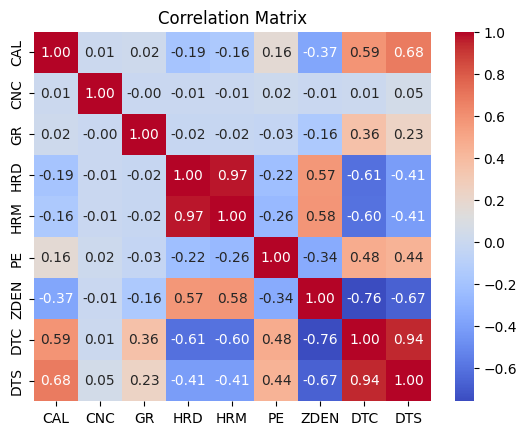

In [20]:
# Correlation Matrix 
corr_matrix = dft.corr(method='pearson')
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

The intent was to use ppscore but issues with instalation with the library has led to using an alrenative MIC as the pearson method above is best suited for linear relationships which this data is not. 


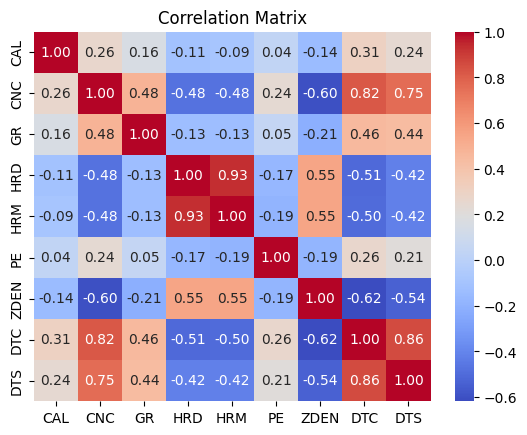

In [22]:
corr_matrix = dft.corr(method='kendall')
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

Running two differnt correlations using two different scoring types one for more linear relationships 
the other not.  Some slight differences in scoring is note. The Kendall method gave some stronger correlations between some features suggesting that there are strong non-linear relationships exist. 

<Axes: xlabel='x', ylabel='y'>

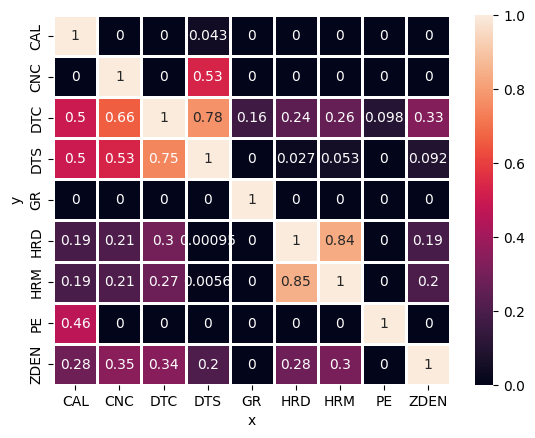

In [24]:
# Going to try and run ppscore now that older version of python installed. 
import ppscore as pps
matrix_df = pps.matrix(dft).pivot(columns='x', index='y',  values='ppscore')
sns.heatmap(matrix_df, vmin=0, vmax=1,  linewidths=1.0,annot=True)

Getting to run ppscore along with the older ways of doing correlation matrix it is clear that even when using differnt methods ppscore is far better at non-linear complext relationships within a dataframe.

# Building the Models 

In [27]:
# Create separate datasets for DTC and DTS
df_dtc = dft.dropna(subset=['DTC'])
df_dts = dft.dropna(subset=['DTS'])

In [28]:
df_dtc= df_dtc.dropna()
df_dts= df_dts.dropna()

In [29]:
#X
df_dtc_x = df_dtc.drop(columns=['DTC','DTS'])
df_dts_x = df_dts.drop(columns=['DTC','DTS'])

In [30]:
#Y
y_dtc = df_dtc['DTC']
y_dts = df_dts['DTS']

In [31]:
X_train_dtc, X_test_dtc, y_train_dtc, y_test_dtc = train_test_split(df_dtc_x,y_dtc, test_size=0.30, random_state=42, shuffle = True)

In [32]:
X_train_dts, X_test_dts, y_train_dts, y_test_dts = train_test_split(df_dts_x,y_dts, test_size=0.30, random_state=42, shuffle = True)

#  Hyper parameters used in X G Boost 
## Training dataframe for DTS,DTC

# DTC

In [35]:
xgb_model_dtc = xgb.XGBRegressor(random_state=42, max_depth=2,learning_rate=0.18, n_estimators=145, min_child_weight = 6, gamma = 0.3)

In [36]:
xgb_model_dtc.fit(X_train_dtc, y_train_dtc)
y_pred_test_dtc = xgb_model_dtc.predict(X_test_dtc)
y_pred_train_dtc = xgb_model_dtc.predict(X_train_dtc)
print("RMSE_train:     " + str(np.sqrt(mean_squared_error(y_train_dtc,y_pred_train_dtc))))
print("RMSE_test:     " + str(np.sqrt(mean_squared_error(y_test_dtc,y_pred_test_dtc))))
print("R2_train:     " + str(r2_score(y_train_dtc,y_pred_train_dtc)))
print("R2_test:     " + str(r2_score(y_test_dtc,y_pred_test_dtc)))

RMSE_train:     3.6395132541518165
RMSE_test:     3.8130813044465572
R2_train:     0.9761344369583579
R2_test:     0.9736840357693544


<Axes: title={'center': 'Feature importance'}, xlabel='Importance score', ylabel='Features'>

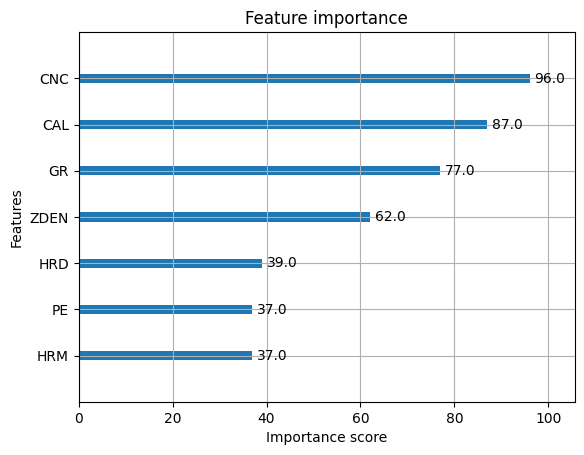

In [37]:
xgb.plot_importance(xgb_model_dtc)

# DTS

In [39]:
xgb_model_dts = xgb.XGBRegressor(random_state=42, max_depth=7,learning_rate=0.19, n_estimators=135, min_child_weight = 6, gamma = 0.7)

In [40]:
xgb_model_dts.fit(X_train_dts, y_train_dts)
y_pred_test_dts = xgb_model_dts.predict(X_test_dts)
y_pred_train_dts = xgb_model_dts.predict(X_train_dts)
print("RMSE_train:     " + str(np.sqrt(mean_squared_error(y_train_dts,y_pred_train_dts))))
print("RMSE_test:     " + str(np.sqrt(mean_squared_error(y_test_dts,y_pred_test_dts))))
print("R2_train:     " + str(r2_score(y_train_dts,y_pred_train_dts)))
print("R2_test:     " + str(r2_score(y_test_dts,y_pred_test_dts)))

RMSE_train:     4.464013144518742
RMSE_test:     8.283328798602609
R2_train:     0.9972059822809354
R2_test:     0.9905539483810054


<Axes: title={'center': 'Feature importance'}, xlabel='Importance score', ylabel='Features'>

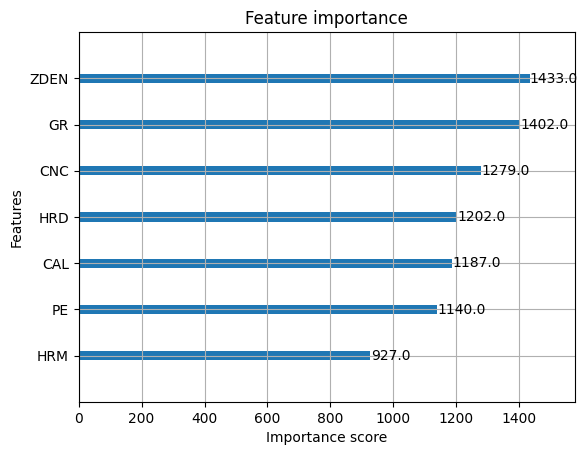

In [41]:
xgb.plot_importance(xgb_model_dts)

# Test Data 
     Running predictions using the test data set

In [43]:
# Preparing the test dataframe 
# Replace value -999 ( missing value indicators ) as NA
ts_df.replace(['-999', -999], np.nan, inplace=True)
# Nullify the Negative Values
col = ['ZDEN', 'GR', 'CNC', 'PE']
ts_df[col] = ts_df [col].mask(dft[col] < 0)

# Nullify the Outliers
ts_df['CNC'][ts_df['CNC']>0.7] = np.nan
ts_df['GR'][(ts_df['GR']>250)] = np.nan
ts_df['HRD'][ts_df['HRD']>200] = np.nan
ts_df['HRM'][ts_df['HRM']>200] = np.nan

        
# Log Transformation
ts_df['HRD'] = np.log(ts_df['HRD'])
ts_df['HRM'] = np.log(ts_df['HRM'])

In [44]:
ts_df.isnull().sum()

CAL      0
CNC      0
GR      33
HRD      1
HRM     27
PE       0
ZDEN     0
dtype: int64

In [45]:
ts_df['GR']= ts_df['GR'].fillna(ts_df['GR'].mean())
ts_df['HRD']= ts_df['HRD'].fillna(ts_df['HRD'].mean())
ts_df['HRM']= ts_df['HRM'].fillna(ts_df['HRM'].mean())

In [46]:
ts_df.isnull().sum()

CAL     0
CNC     0
GR      0
HRD     0
HRM     0
PE      0
ZDEN    0
dtype: int64

In [47]:
ts_df.shape

(11088, 7)

In [48]:
test_x= ts_df.copy()

In [49]:
ts_df['DTC'] = xgb_model_dtc.predict(test_x)
ts_df['DTS'] = xgb_model_dts.predict(test_x)

In [50]:
ts_df

,CAL,CNC,GR,HRD,HRM,PE,ZDEN,DTC,DTS
0,8.5781,0.3521,55.1824,-0.208132,-0.247180,6.8291,2.3256,105.429443,229.067123
1,8.5781,0.3639,57.0114,-0.218405,-0.258382,6.8100,2.3255,105.429443,231.237991
2,8.5781,0.3703,58.9263,-0.295177,-0.349841,6.7766,2.3212,106.037430,227.584030
3,8.5625,0.3667,57.3308,-0.332819,-0.424342,6.7219,2.3119,106.443596,228.283783
4,8.5781,0.3500,53.0624,-0.379067,-0.492822,6.6384,2.2982,107.069725,229.288574
...,...,...,...,...,...,...,...,...,...
11083,8.7813,0.1882,68.0333,0.027615,-0.018673,6.5003,2.4423,81.792297,147.697113
11084,8.7344,0.1879,68.0753,0.024595,-0.017960,6.4415,2.4377,81.792297,147.697113
11085,8.7266,0.1824,68.8516,0.044878,0.019705,6.3413,2.4342,79.734497,147.607071
11086,8.7500,0.1822,70.8515,0.059118,0.052687,6.2254,2.4320,79.734497,144.115189


In [51]:
# Reading in orginal dataset ( 
dfr = pd.read_csv(url)
dfr.shape

(11088, 2)

In [52]:
pred_df= ts_df[['DTC','DTS']]
pred_df.shape

(11088, 2)

In [53]:
preds= np.array(pred_df)
reals= np.real(dfr)

In [54]:
def result_plot(y_predict, y_real):
    # check the accuracy of predicted data and plot the result
    print('Combined r2 score is:', '{:.5f}'.format((r2_score(y_real, y_predict))))
    dtc_real = y_real[:, 0]
    dtc_pred = y_predict[:, 0]
    dts_real = y_real[:, 1]
    dts_pred = y_predict[:, 1]
    print('DTC:', '{:.5f}'.format((r2_score(dtc_real, dtc_pred))))
    print('DTS:', '{:.5f}'.format((r2_score(dts_real, dts_pred))))
    plt.subplots(nrows=2, ncols=2, figsize=(16,10))
    plt.subplot(2, 2, 1)
    plt.plot(y_real[:, 0])
    plt.plot(y_predict[:, 0])
    plt.legend(['True', 'Predicted'])
    plt.xlabel('Sample')
    plt.ylabel('DTC')
    plt.title('DTC Prediction Comparison')

    plt.subplot(2, 2, 2)
    plt.plot(y_real[:, 1])
    plt.plot(y_predict[:, 1])
    plt.legend(['True', 'Predicted'])
    plt.xlabel('Sample')
    plt.ylabel('DTS')
    plt.title('DTS Prediction Comparison')
    
    plt.subplot(2, 2, 3)
    plt.scatter(y_real[:, 0], y_predict[:, 0])
    plt.xlabel('Real Value')
    plt.ylabel('Predicted Value')
    plt.title('DTC Prediction Comparison')
    
    plt.subplot(2, 2, 4)
    plt.scatter(y_real[:, 1], y_predict[:, 1])
    plt.xlabel('Real Value')
    plt.ylabel('Predicted Value')
    plt.title('DTS Prediction Comparison')

    plt.show()

Combined r2 score is: 0.82008
DTC: 0.91115
DTS: 0.72901


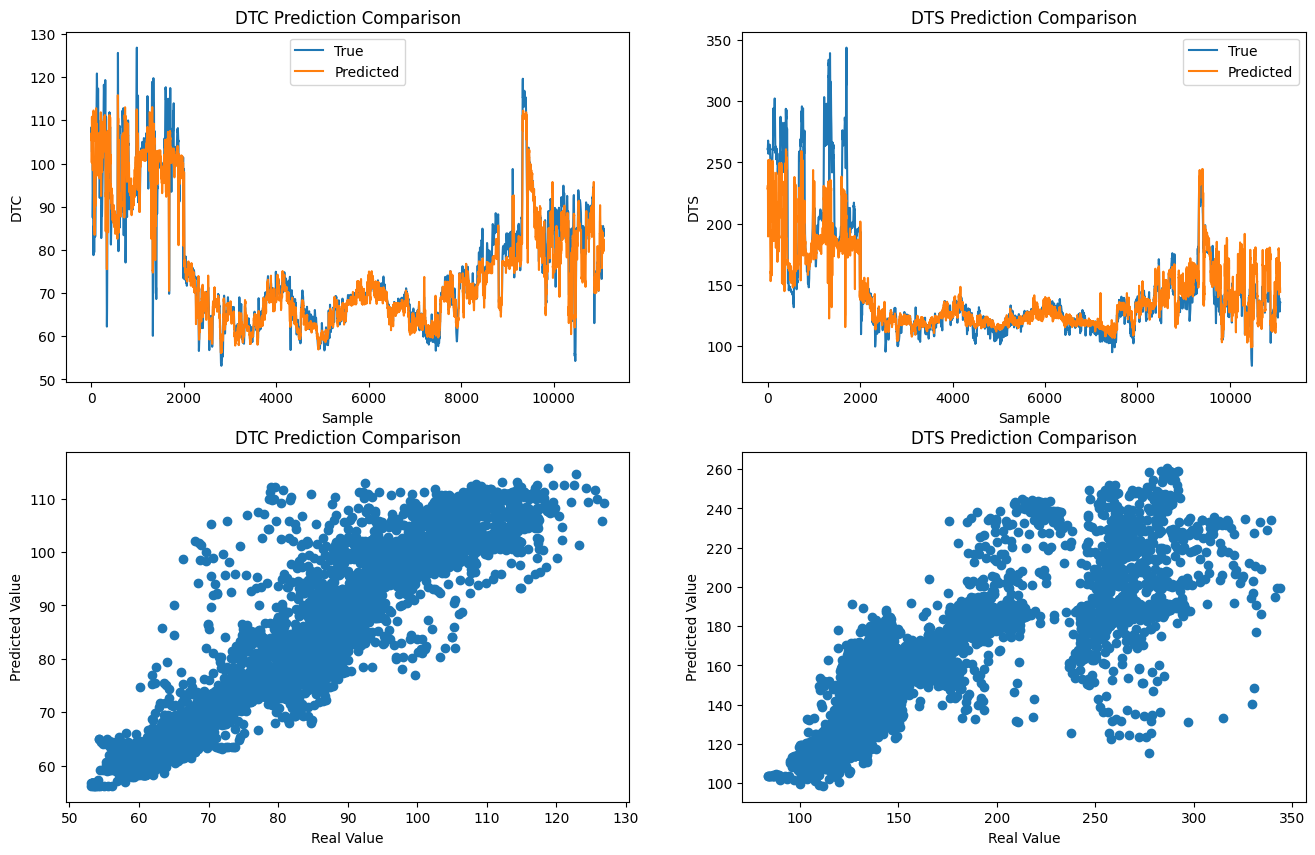

In [55]:
result_plot(preds,reals)

RMSE of test data (#1 DTC): 4.32
RMSE of test data (#2 DTS): 23.11
Overall RMSE = 16.62


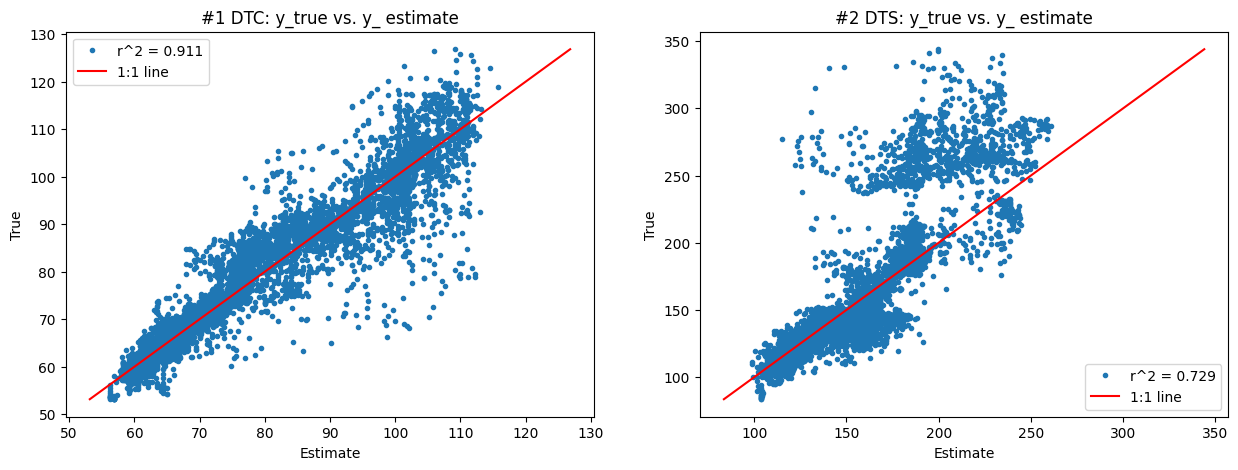

In [56]:
# Plot results:
plt.figure(figsize=(15,5))
i = 0
plt.subplot(1,2,i+1)
plt.plot(preds[:,i], reals[:,i], '.', label = 'r^2 = %.3f' % ((r2_score(reals[:,i], preds[:,i]))))
plt.plot([reals[:,i].min(),reals[:,i].max()],[reals[:,i].min(),reals[:,i].max()], 'r', label = '1:1 line')
plt.title('#1 DTC: y_true vs. y_ estimate'); plt.xlabel('Estimate'); plt.ylabel('True')
plt.legend()
i += 1
plt.subplot(1,2,i+1)
plt.plot(preds[:,i], reals[:,i], '.', label = 'r^2 = %.3f' % ((r2_score(reals[:,i], preds[:,i]))))
plt.plot([reals[:,i].min(),reals[:,i].max()],[reals[:,i].min(),reals[:,i].max()], 'r', label = '1:1 line')
plt.title('#2 DTS: y_true vs. y_ estimate'); plt.xlabel('Estimate'); plt.ylabel('True')
plt.legend()

MSE_0 = mean_squared_error(reals[:,0], preds[:,0]);
RMSE_0 = np.sqrt(mean_squared_error(reals[:,0], preds[:,0]));
MSE_1 = mean_squared_error(reals[:,1], preds[:,1]);
RMSE_1 = np.sqrt(mean_squared_error(reals[:,1], preds[:,1]));
print('RMSE of test data (#1 DTC): %.2f' %(RMSE_0))
print('RMSE of test data (#2 DTS): %.2f' %(RMSE_1))
print('Overall RMSE = %.2f' %np.sqrt((MSE_0+MSE_1)/2))

# Using Pycaret

In [58]:
from pycaret.regression import *

In [59]:
df_dtspycaret= df_dts.drop(['DTC'],axis=1)

In [60]:
model= setup(data= df_dtspycaret, target= 'DTS',normalize= True,remove_outliers=True,profile=True)

,Description,Value
0,Session id,8505
1,Target,DTS
2,Target type,Regression
3,Original data shape,"(20516, 8)"
4,Transformed data shape,"(19798, 8)"
5,Transformed train set shape,"(13643, 8)"
6,Transformed test set shape,"(6155, 8)"
7,Numeric features,7
8,Preprocess,True
9,Imputation type,simple


Loading profile... Please Wait!
Profiler Failed. No output to show, continue with modeling.


In [61]:
xgb= create_model('xgboost')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,5.3306,85.6964,9.2572,0.9881,0.0476,0.0300
1,5.3209,79.4365,8.9127,0.9888,0.0462,0.0300
2,5.6941,131.9493,11.4869,0.9807,0.0529,0.0316
3,5.6318,93.0165,9.6445,0.9872,0.0468,0.0306
4,5.8602,133.5024,11.5543,0.9819,0.0529,0.0318
5,6.0411,116.9226,10.8131,0.9845,0.0531,0.0325
6,5.7972,107.7377,10.3797,0.9843,0.0494,0.0317
7,5.6081,84.3968,9.1868,0.9888,0.0478,0.0312
8,5.3593,77.6281,8.8107,0.9887,0.0455,0.0299


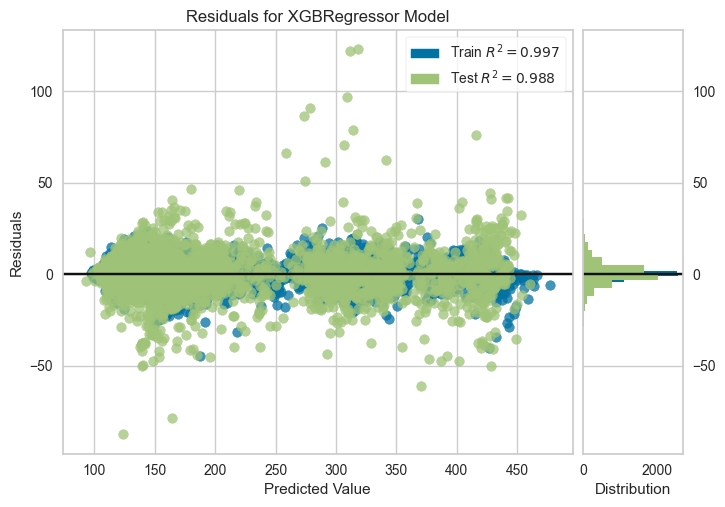

In [62]:
plot_model(xgb)

# For DTC

In [64]:
df_dtcpycaret= df_dtc.drop(['DTS'],axis=1)

In [65]:
model= setup(data= df_dtspycaret, target= 'DTS',normalize= True,remove_outliers=True,profile=True)

,Description,Value
0,Session id,6809
1,Target,DTS
2,Target type,Regression
3,Original data shape,"(20516, 8)"
4,Transformed data shape,"(19798, 8)"
5,Transformed train set shape,"(13643, 8)"
6,Transformed test set shape,"(6155, 8)"
7,Numeric features,7
8,Preprocess,True
9,Imputation type,simple


Loading profile... Please Wait!
Profiler Failed. No output to show, continue with modeling.


In [66]:
xgb= create_model('xgboost')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,5.6262,85.0443,9.2219,0.9889,0.0457,0.0303
1,5.4199,96.1306,9.8046,0.9867,0.0494,0.0304
2,5.8356,94.7099,9.7319,0.9875,0.0496,0.0322
3,5.9425,121.4206,11.0191,0.9832,0.0533,0.0324
4,5.5119,79.5427,8.9187,0.9871,0.0486,0.0317
5,5.4142,87.9125,9.3762,0.9871,0.0465,0.0297
6,5.4843,85.2819,9.2348,0.9882,0.0454,0.0299
7,5.7299,89.8611,9.4795,0.9875,0.0489,0.0313
8,5.5363,105.5614,10.2743,0.9852,0.0498,0.0306


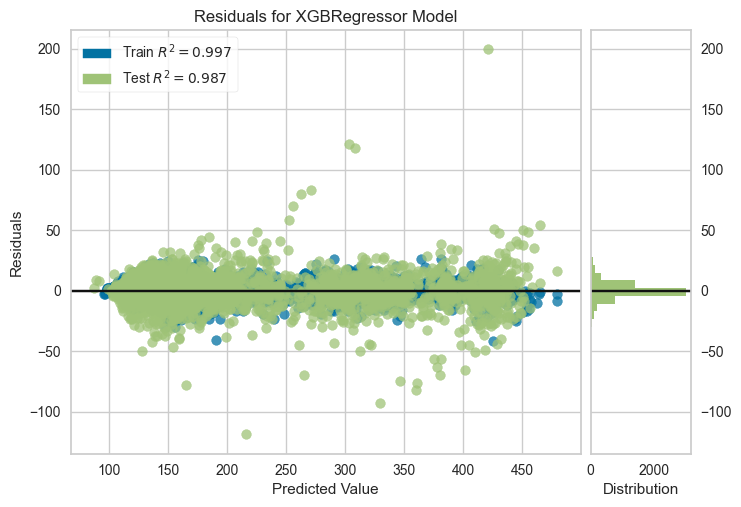

In [67]:
plot_model(xgb)

# Wavelt Transform
    So far the data has been approached from typical approaces.  Doing this will decompose the signal into frequency components which 
    will allow for more detailed analysis of the sonic logs.  This decompostion seperates out the temporal and sparial features which in turn can lead to imporved feature extractions. 

In [69]:
import shap
# load JS visualization code to notebook
shap.initjs()
# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn and spark models)
explainer = shap.TreeExplainer(xgb_model_dts)

In [70]:
shap_values = explainer.shap_values(test_x)

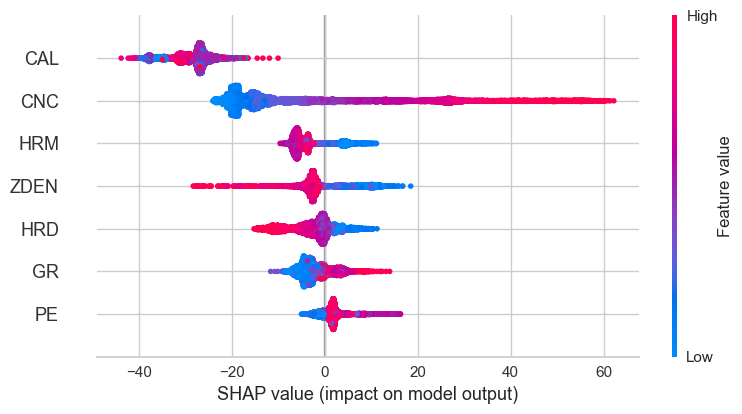

In [71]:
# summarize the effects of all the features
shap.summary_plot(shap_values, test_x)

In [72]:
#This function is defined for descrete wavelet transform and calculating the cA ie the approximate coefficient
def make_dwt_vars_cA(wells_df,logs,levels,wavelet):

    wave= pywt.Wavelet(wavelet)
    
    grouped = wells_df
    new_df = pd.DataFrame()
    for key in grouped.keys():
    
        depth = grouped['Depth']
        temp_df = pd.DataFrame()
        temp_df['Depth'] = depth
        for log in logs:
      
            temp_data = grouped[log]
              
            for i in levels:
                
                    cA_cD = pywt.wavedec(temp_data,wave,level=i,mode='symmetric')
                    cA = cA_cD[0]
                    new_depth = np.linspace(min(depth),max(depth),len(cA))
                    fA = interp1d(new_depth,cA,kind='nearest')
                    temp_df[log + '_cA_level_' + str(i)] = fA(depth)
    
        new_df = new_df.append(temp_df)
        
    new_df = new_df.sort_index()
    new_df = new_df.drop(['Depth'],axis=1)
    return new_df

In [73]:
#This is a user defined function for discrte wavelet transform cD, cD is also called the detailed  coefficient
## There is no depth feature so this creates some
def make_dwt_vars_cD(wells_df,logs,levels,wavelet):

    wave= pywt.Wavelet(wavelet)
    
    grouped = wells_df
    new_df = pd.DataFrame()
    for key in grouped.keys():
    
        depth = grouped['Depth']
        temp_df = pd.DataFrame()
        temp_df['Depth'] = depth
        for log in logs:
      
            temp_data = grouped[log]

            cA_4, cD_4, cD_3, cD_2, cD_1 = pywt.wavedec(temp_data,wave,level=4,mode='symmetric')
            dict_cD_levels = {1:cD_1, 2:cD_2, 3:cD_3, 4:cD_4}
                
            for i in levels:
                new_depth = np.linspace(min(depth),max(depth),len(dict_cD_levels[i]))
                fA = interp1d(new_depth,dict_cD_levels[i],kind='nearest')
                temp_df[log + '_cD_level_' + str(i)] = fA(depth)
    
        new_df = new_df.append(temp_df)
        
    new_df = new_df.sort_index()
    new_df = new_df.drop(['Depth'],axis=1)
    return new_df

Getting the "TRAIN" data ready 

In [75]:
df_wavelet= dft.copy()

In [76]:
df_wavelet= df_wavelet.dropna()

In [77]:
df_wavelet.shape

(20516, 9)

In [78]:
depth_train= np.linspace(500,4000,len(df_wavelet))

In [79]:
df_wavelet['Depth']= depth_train

# dB4 Wavelet Transformation 

In [81]:
import pywt
from scipy.interpolate import interp1d

In [82]:
#cD From wavelet db4
dwt_db4_cD_df = make_dwt_vars_cD(wells_df=df_wavelet, logs=['CNC'],levels=[1, 2, 3, 4], wavelet='db4')

# cA From wavelet db4
dwt_db4_cA_df = make_dwt_vars_cA(wells_df=df_wavelet, logs=['CNC'],levels=[1, 2, 3, 4], wavelet='db4')

In [83]:
list_df_var = [dwt_db4_cD_df, dwt_db4_cA_df]
combined_df = df_wavelet
for var_df in list_df_var:
    temp_df = var_df
    combined_df = pd.concat([combined_df,temp_df],axis=1)
combined_df.replace(to_replace=np.nan, value='-1', inplace=True)
print (combined_df.shape)
training_data=combined_df

(205160, 18)


In [84]:
df_zone1= training_data[training_data['Depth']<1000]

Text(0.5, 0.94, 'CMC log and corresponding cD cofficients found via db4 for Well: ')

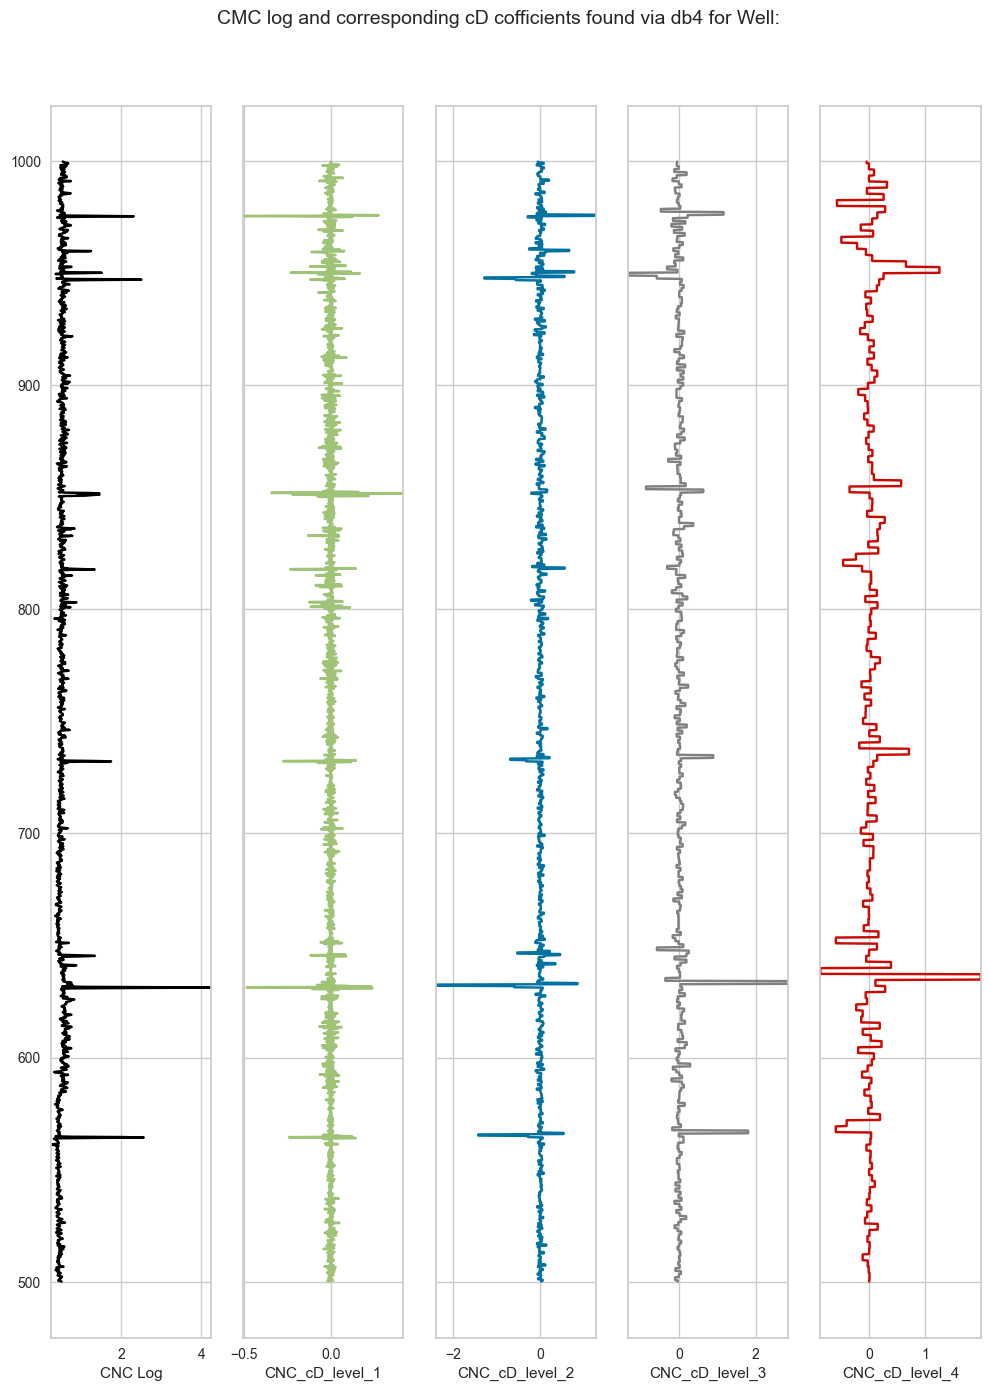

In [85]:
f, ax = plt.subplots(nrows=1, ncols=5, figsize=(12, 16))
ax[0].plot(df_zone1.CNC, df_zone1.Depth, '-', color='black')
ax[1].plot(df_zone1.CNC_cD_level_1, df_zone1.Depth, '-g')
ax[2].plot(df_zone1.CNC_cD_level_2, df_zone1.Depth, '-')
ax[3].plot(df_zone1.CNC_cD_level_3, df_zone1.Depth, '-', color='0.5')
ax[4].plot(df_zone1.CNC_cD_level_4, df_zone1.Depth, '-', color='r')

ax[0].set_xlabel("CNC Log")
ax[0].set_xlim(df_zone1.CNC.min(),df_zone1.CNC.max())
ax[1].set_xlabel("CNC_cD_level_1")
ax[1].set_xlim(df_zone1.CNC_cD_level_1.min(),df_zone1.CNC_cD_level_1.max())
ax[2].set_xlabel("CNC_cD_level_2")
ax[2].set_xlim(df_zone1.CNC_cD_level_2.min(),df_zone1.CNC_cD_level_2.max())
ax[3].set_xlabel("CNC_cD_level_3")
ax[3].set_xlim(df_zone1.CNC_cD_level_3.min(),df_zone1.CNC_cD_level_3.max())
ax[4].set_xlabel("CNC_cD_level_4")
ax[4].set_xlim(df_zone1.CNC_cD_level_4.min(),df_zone1.CNC_cD_level_4.max())

ax[1].set_yticklabels([]); ax[2].set_yticklabels([]); ax[3].set_yticklabels([])
ax[4].set_yticklabels([]); 

f.suptitle('CMC log and corresponding cD cofficients found via db4 for Well: ', fontsize=14,y=0.94)

In [86]:
# Create separate datasets for DTC and DTS
df_dtc_wave = training_data.dropna(subset=['DTC'])
df_dts_wave = training_data.dropna(subset=['DTS'])

In [87]:
df_dtc_x_wave = df_dtc_wave.drop(columns=['DTC','DTS'])
df_dts_x_wave = df_dts_wave.drop(columns=['DTC','DTS'])

In [88]:
y_dtc_wave = df_dtc_wave['DTC']
y_dts_wave = df_dts_wave['DTS']

In [89]:
X_train_dtc_wave, X_test_dtc_wave, y_train_dtc_wave, y_test_dtc_wave = train_test_split(df_dtc_x_wave,y_dtc_wave, test_size=0.30, random_state=42, shuffle = True)

In [90]:
X_train_dts_wave, X_test_dts_wave, y_train_dts_wave, y_test_dts_wave = train_test_split(df_dts_x_wave,y_dts_wave, test_size=0.30, random_state=42, shuffle = True)

# Now for DTC

In [92]:
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb

xgb_model_dtc_wave = xgb.XGBRegressor(random_state=42, max_depth=2,learning_rate=0.18, n_estimators=145, min_child_weight = 6, gamma = 0.3)

In [93]:
xgb_model_dtc_wave.fit(X_train_dtc_wave, y_train_dtc_wave)
y_pred_test_dtc_wave = xgb_model_dtc_wave.predict(X_test_dtc_wave)
y_pred_train_dtc_wave = xgb_model_dtc_wave.predict(X_train_dtc_wave)
print("RMSE_train:     " + str(np.sqrt(mean_squared_error(y_train_dtc_wave,y_pred_train_dtc_wave))))
print("RMSE_test:     " + str(np.sqrt(mean_squared_error(y_test_dtc_wave,y_pred_test_dtc_wave))))
print("R2_train:     " + str(r2_score(y_train_dtc_wave,y_pred_train_dtc_wave)))
print("R2_test:     " + str(r2_score(y_test_dtc_wave,y_pred_test_dtc_wave)))

RMSE_train:     3.2301557598846187
RMSE_test:     3.290077547810552
R2_train:     0.9812168365810492
R2_test:     0.9803698414696382


# DTS

In [95]:
xgb_model_dts_wave = xgb.XGBRegressor(random_state=42, max_depth=7,learning_rate=0.19, n_estimators=135, min_child_weight = 6, gamma = 0.7)

In [96]:
xgb_model_dts_wave.fit(X_train_dts_wave, y_train_dts_wave)
y_pred_test_dts_wave = xgb_model_dts_wave.predict(X_test_dts_wave)
y_pred_train_dts_wave = xgb_model_dts_wave.predict(X_train_dts_wave)
print("RMSE_train:     " + str(np.sqrt(mean_squared_error(y_train_dts_wave,y_pred_train_dts_wave))))
print("RMSE_test:     " + str(np.sqrt(mean_squared_error(y_test_dts_wave,y_pred_test_dts_wave))))
print("R2_train:     " + str(r2_score(y_train_dts_wave,y_pred_train_dts_wave)))
print("R2_test:     " + str(r2_score(y_test_dts_wave,y_pred_test_dts_wave)))

RMSE_train:     2.1236387949278055
RMSE_test:     2.25055144635141
R2_train:     0.999370891197755
R2_test:     0.9992944415708158


## Predictions for test data 

In [98]:
merge= [test_x,dfr]
wavelet_test_df= pd.concat(merge,axis=1)
print(wavelet_test_df.shape)
wavelet_test_df


(11088, 9)


,CAL,CNC,GR,HRD,HRM,PE,ZDEN,DTC,DTS
0,8.5781,0.3521,55.1824,-0.208132,-0.247180,6.8291,2.3256,107.0669,261.0363
1,8.5781,0.3639,57.0114,-0.218405,-0.258382,6.8100,2.3255,107.8095,260.1601
2,8.5781,0.3703,58.9263,-0.295177,-0.349841,6.7766,2.3212,108.2305,261.0667
3,8.5625,0.3667,57.3308,-0.332819,-0.424342,6.7219,2.3119,108.4281,262.5100
4,8.5781,0.3500,53.0624,-0.379067,-0.492822,6.6384,2.2982,108.2227,263.3599
...,...,...,...,...,...,...,...,...,...
11083,8.7813,0.1882,68.0333,0.027615,-0.018673,6.5003,2.4423,83.1931,133.2146
11084,8.7344,0.1879,68.0753,0.024595,-0.017960,6.4415,2.4377,83.3988,134.3225
11085,8.7266,0.1824,68.8516,0.044878,0.019705,6.3413,2.4342,83.7630,135.2511
11086,8.7500,0.1822,70.8515,0.059118,0.052687,6.2254,2.4320,84.5598,135.9369


In [99]:
depth_test= np.linspace(500,4000,len(wavelet_test_df))
wavelet_test_df['Depth']= depth_test
wavelet_test_df.isnull().sum()

CAL        0
CNC        0
GR         0
HRD        0
HRM        0
PE         0
ZDEN       0
DTC        0
DTS        0
Depth      0
dtype: int64

In [100]:
#cD From wavelet db4
dwt_db4_cD_df = make_dwt_vars_cD(wells_df=wavelet_test_df, logs=['CNC'],levels=[1, 2, 3, 4], wavelet='db4')

# cA From wavelet db4
dwt_db4_cA_df = make_dwt_vars_cA(wells_df=wavelet_test_df, logs=['CNC'],levels=[1, 2, 3, 4], wavelet='db4')

In [101]:

list_df_var = [dwt_db4_cD_df, dwt_db4_cA_df]
combined_df = wavelet_test_df
for var_df in list_df_var:
    temp_df = var_df
    combined_df = pd.concat([combined_df,temp_df],axis=1)
combined_df.replace(to_replace=np.nan, value='-1', inplace=True)
print (combined_df.shape)
testing_data=combined_df

(110880, 18)


In [102]:
testing_data.columns
final_test_df= testing_data.drop(['DTC    ','DTS  '],axis=1)
final_test_df_dtc= final_test_df.copy()
final_test_df_dts= final_test_df.copy()

### Predictions

In [104]:
X_train_dtc_wave.columns
final_test_df_dtc.columns
final_test_df_dts.columns
final_test_df['DTC']= xgb_model_dtc_wave.predict(final_test_df_dtc)
final_test_df['DTS']= xgb_model_dts_wave.predict(final_test_df_dts)
final_test_df

,CAL,CNC,GR,HRD,HRM,PE,ZDEN,Depth,CNC_cD_level_1,CNC_cD_level_2,CNC_cD_level_3,CNC_cD_level_4,CNC_cA_level_1,CNC_cA_level_2,CNC_cA_level_3,CNC_cA_level_4,DTC,DTS
0,8.5781,0.3521,55.1824,-0.208132,-0.247180,6.8291,2.3256,500.0,0.001117,-0.006163,-0.003264,0.000376,0.497537,0.716567,1.010954,1.426520,113.862289,253.210495
0,8.5781,0.3521,55.1824,-0.208132,-0.247180,6.8291,2.3256,500.0,0.001117,-0.006163,-0.003264,0.000376,0.497537,0.716567,1.010954,1.426520,113.862289,253.210495
0,8.5781,0.3521,55.1824,-0.208132,-0.247180,6.8291,2.3256,500.0,0.001117,-0.006163,-0.003264,0.000376,0.497537,0.716567,1.010954,1.426520,113.862289,253.210495
0,8.5781,0.3521,55.1824,-0.208132,-0.247180,6.8291,2.3256,500.0,0.001117,-0.006163,-0.003264,0.000376,0.497537,0.716567,1.010954,1.426520,113.862289,253.210495
0,8.5781,0.3521,55.1824,-0.208132,-0.247180,6.8291,2.3256,500.0,0.001117,-0.006163,-0.003264,0.000376,0.497537,0.716567,1.010954,1.426520,113.862289,253.210495
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11087,8.7500,0.1840,69.9109,0.058458,0.044304,6.1295,2.4313,4000.0,-0.002173,-0.001641,0.014239,-0.026695,0.260296,0.364561,0.511405,0.717311,75.098671,142.365128
11087,8.7500,0.1840,69.9109,0.058458,0.044304,6.1295,2.4313,4000.0,-0.002173,-0.001641,0.014239,-0.026695,0.260296,0.364561,0.511405,0.717311,75.098671,142.365128
11087,8.7500,0.1840,69.9109,0.058458,0.044304,6.1295,2.4313,4000.0,-0.002173,-0.001641,0.014239,-0.026695,0.260296,0.364561,0.511405,0.717311,75.098671,142.365128
11087,8.7500,0.1840,69.9109,0.058458,0.044304,6.1295,2.4313,4000.0,-0.002173,-0.001641,0.014239,-0.026695,0.260296,0.364561,0.511405,0.717311,75.098671,142.365128


In [105]:
testing_data

,CAL,CNC,GR,HRD,HRM,PE,ZDEN,DTC,DTS,Depth,CNC_cD_level_1,CNC_cD_level_2,CNC_cD_level_3,CNC_cD_level_4,CNC_cA_level_1,CNC_cA_level_2,CNC_cA_level_3,CNC_cA_level_4
0,8.5781,0.3521,55.1824,-0.208132,-0.247180,6.8291,2.3256,107.0669,261.0363,500.0,0.001117,-0.006163,-0.003264,0.000376,0.497537,0.716567,1.010954,1.426520
0,8.5781,0.3521,55.1824,-0.208132,-0.247180,6.8291,2.3256,107.0669,261.0363,500.0,0.001117,-0.006163,-0.003264,0.000376,0.497537,0.716567,1.010954,1.426520
0,8.5781,0.3521,55.1824,-0.208132,-0.247180,6.8291,2.3256,107.0669,261.0363,500.0,0.001117,-0.006163,-0.003264,0.000376,0.497537,0.716567,1.010954,1.426520
0,8.5781,0.3521,55.1824,-0.208132,-0.247180,6.8291,2.3256,107.0669,261.0363,500.0,0.001117,-0.006163,-0.003264,0.000376,0.497537,0.716567,1.010954,1.426520
0,8.5781,0.3521,55.1824,-0.208132,-0.247180,6.8291,2.3256,107.0669,261.0363,500.0,0.001117,-0.006163,-0.003264,0.000376,0.497537,0.716567,1.010954,1.426520
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11087,8.7500,0.1840,69.9109,0.058458,0.044304,6.1295,2.4313,84.8668,135.7406,4000.0,-0.002173,-0.001641,0.014239,-0.026695,0.260296,0.364561,0.511405,0.717311
11087,8.7500,0.1840,69.9109,0.058458,0.044304,6.1295,2.4313,84.8668,135.7406,4000.0,-0.002173,-0.001641,0.014239,-0.026695,0.260296,0.364561,0.511405,0.717311
11087,8.7500,0.1840,69.9109,0.058458,0.044304,6.1295,2.4313,84.8668,135.7406,4000.0,-0.002173,-0.001641,0.014239,-0.026695,0.260296,0.364561,0.511405,0.717311
11087,8.7500,0.1840,69.9109,0.058458,0.044304,6.1295,2.4313,84.8668,135.7406,4000.0,-0.002173,-0.001641,0.014239,-0.026695,0.260296,0.364561,0.511405,0.717311


In [106]:
testing_data.columns

Index(['CAL', 'CNC', 'GR', 'HRD', 'HRM', 'PE', 'ZDEN', 'DTC    ', 'DTS  ',
       'Depth', 'CNC_cD_level_1', 'CNC_cD_level_2', 'CNC_cD_level_3',
       'CNC_cD_level_4', 'CNC_cA_level_1', 'CNC_cA_level_2', 'CNC_cA_level_3',
       'CNC_cA_level_4'],
      dtype='object')

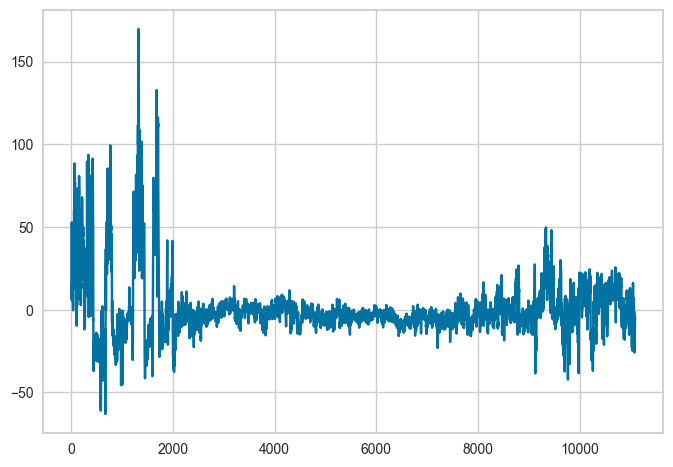

In [107]:
pred_wave_df= final_test_df[['DTC','DTS']]
real_wave_df= testing_data[['DTC    ','DTS  ']]
preds_wave= np.array(pred_wave_df)
reals_wave= np.array(real_wave_df)
merge1= [testing_data['DTS  '],final_test_df['DTS']]
dts= pd.concat(merge1,axis=1)
dts['res']= dts['DTS  ']-dts['DTS']
plt.plot(dts['res'])

#### Trying wavelet on another feature: Caliper log for DTS prediction

In [212]:
df_wavelet_cal= dft.copy()
df_wavelet_cal= df_wavelet_cal.dropna()
depth_train_cal= np.linspace(500,4000,len(df_wavelet_cal))
df_wavelet_cal['Depth']= depth_train_cal
#cD From wavelet db4
dwt_db4_cD_df_cal = make_dwt_vars_cD(wells_df=df_wavelet_cal, logs=['CAL'],levels=[1, 2, 3, 4], wavelet='db4')

# cA From wavelet db4
dwt_db4_cA_df_cal = make_dwt_vars_cA(wells_df=df_wavelet_cal, logs=['CAL'],levels=[1, 2, 3, 4], wavelet='db4')
list_df_var_cal = [dwt_db4_cD_df_cal, dwt_db4_cA_df_cal]
combined_df_cal = df_wavelet_cal
for var_df_cal in list_df_var_cal:
    temp_df_cal = var_df_cal
    combined_df_cal = pd.concat([combined_df_cal,temp_df_cal],axis=1)
combined_df_cal.replace(to_replace=np.nan, value='-1', inplace=True)
print (combined_df_cal.shape)
training_data_cal=combined_df_cal

df_dts_x_wave_cal = training_data_cal.drop(columns=['DTC','DTS'])
y_dts_wave_cal = training_data_cal['DTS']

X_train_dts_wave_cal, X_test_dts_wave_cal, y_train_dts_wave_cal, y_test_dts_wave_cal = train_test_split(df_dts_x_wave_cal,y_dts_wave_cal, test_size=0.30, random_state=42, shuffle = True)

xgb_model_dts_wave_cal = xgb.XGBRegressor(random_state=42, max_depth=7,learning_rate=0.19, n_estimators=135, min_child_weight = 6, gamma = 0.7)
xgb_model_dts_wave_cal.fit(X_train_dts_wave_cal, y_train_dts_wave_cal)
y_pred_test_dts_wave_cal = xgb_model_dts_wave_cal.predict(X_test_dts_wave_cal)
y_pred_train_dts_wave_cal = xgb_model_dts_wave_cal.predict(X_train_dts_wave_cal)
print("RMSE_train:     " + str(np.sqrt(mean_squared_error(y_train_dts_wave_cal,y_pred_train_dts_wave_cal))))
print("RMSE_test:     " + str(np.sqrt(mean_squared_error(y_test_dts_wave_cal,y_pred_test_dts_wave_cal))))
print("R2_train:     " + str(r2_score(y_train_dts_wave_cal,y_pred_train_dts_wave_cal)))
print("R2_test:     " + str(r2_score(y_test_dts_wave_cal,y_pred_test_dts_wave_cal)))




(205160, 18)
RMSE_train:     2.217258808704243
RMSE_test:     2.3439423912138135
R2_train:     0.9993142003824469
R2_test:     0.9992346696053175


In [214]:
# Finding instances of Variable tr_df
wavelet_test_df= wavelet_test_df[2000:]
wavelet_test_df

,CAL,CNC,GR,HRD,HRM,PE,ZDEN,DTC,DTS,Depth
4000,8.6250,0.1249,7.3635,1.035601,1.254191,8.2452,2.5312,69.8933,122.6606,1762.740146
4001,8.6250,0.1256,7.0240,1.038792,1.259597,8.3271,2.5290,69.8431,122.5735,1763.055831
4002,8.6250,0.1256,7.1169,1.028655,1.265848,8.3789,2.5256,69.8397,122.6851,1763.371516
4003,8.6250,0.1259,8.5035,1.028333,1.268243,8.3908,2.5212,69.8247,122.8339,1763.687201
4004,8.6250,0.1317,8.5561,1.017981,1.251677,8.3872,2.5176,69.8422,123.0917,1764.002886
...,...,...,...,...,...,...,...,...,...,...
11083,8.7813,0.1882,68.0333,0.027615,-0.018673,6.5003,2.4423,83.1931,133.2146,3998.737260
11084,8.7344,0.1879,68.0753,0.024595,-0.017960,6.4415,2.4377,83.3988,134.3225,3999.052945
11085,8.7266,0.1824,68.8516,0.044878,0.019705,6.3413,2.4342,83.7630,135.2511,3999.368630
11086,8.7500,0.1822,70.8515,0.059118,0.052687,6.2254,2.4320,84.5598,135.9369,3999.684315


In [216]:
#cD From wavelet db4
dwt_db4_cD_df = make_dwt_vars_cD(wells_df=wavelet_test_df, logs=['CAL'],levels=[1, 2, 3, 4], wavelet='db4')

# cA From wavelet db4
dwt_db4_cA_df = make_dwt_vars_cA(wells_df=wavelet_test_df, logs=['CAL'],levels=[1, 2, 3, 4], wavelet='db4')


list_df_var = [dwt_db4_cD_df, dwt_db4_cA_df]
combined_df = wavelet_test_df
for var_df in list_df_var:
    temp_df = var_df
    combined_df = pd.concat([combined_df,temp_df],axis=1)
combined_df.replace(to_replace=np.nan, value='-1', inplace=True)
print (combined_df.shape)
testing_data=combined_df



(70880, 18)


In [218]:
testing_data_cal=combined_df

final_test_df_cal= testing_data_cal.drop(['DTC    ','DTS  '],axis=1)
final_test_df_dts_cal= final_test_df_cal.copy()

final_test_df_dts_cal['DTS']= xgb_model_dts_wave_cal.predict(final_test_df_dts_cal)

#print(r2_score(testing_data_cal['DTS  '],final_test_df_cal['DTS']))

In [220]:
final_test_df_dts_cal['DTS']

4000     139.402420
4000     139.402420
4000     139.402420
4000     139.402420
4000     139.402420
            ...    
11087    134.352554
11087    134.352554
11087    134.352554
11087    134.352554
11087    134.352554
Name: DTS, Length: 70880, dtype: float32

In [222]:
final_test_df_dts_cal['DTS']

4000     139.402420
4000     139.402420
4000     139.402420
4000     139.402420
4000     139.402420
            ...    
11087    134.352554
11087    134.352554
11087    134.352554
11087    134.352554
11087    134.352554
Name: DTS, Length: 70880, dtype: float32

In [224]:
print(np.sqrt(r2_score(testing_data_cal['DTS  '],final_test_df_dts_cal['DTS'])))

0.8437228480087345


In [226]:
merge1= [testing_data_cal['DTS  '],final_test_df_dts_cal['DTS']]
dts1= pd.concat(merge1,axis=1)

In [228]:
dts1['res']= dts1['DTS  ']-dts1['DTS']

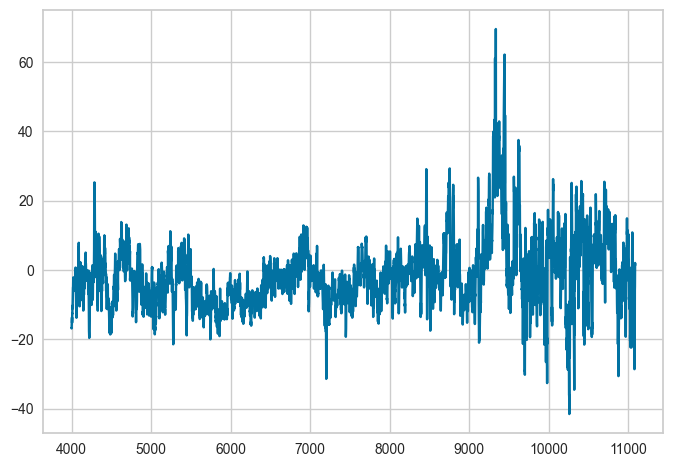

In [230]:
plt.plot(dts1['res'])

DTC: 0.92843
DTS: 0.84372


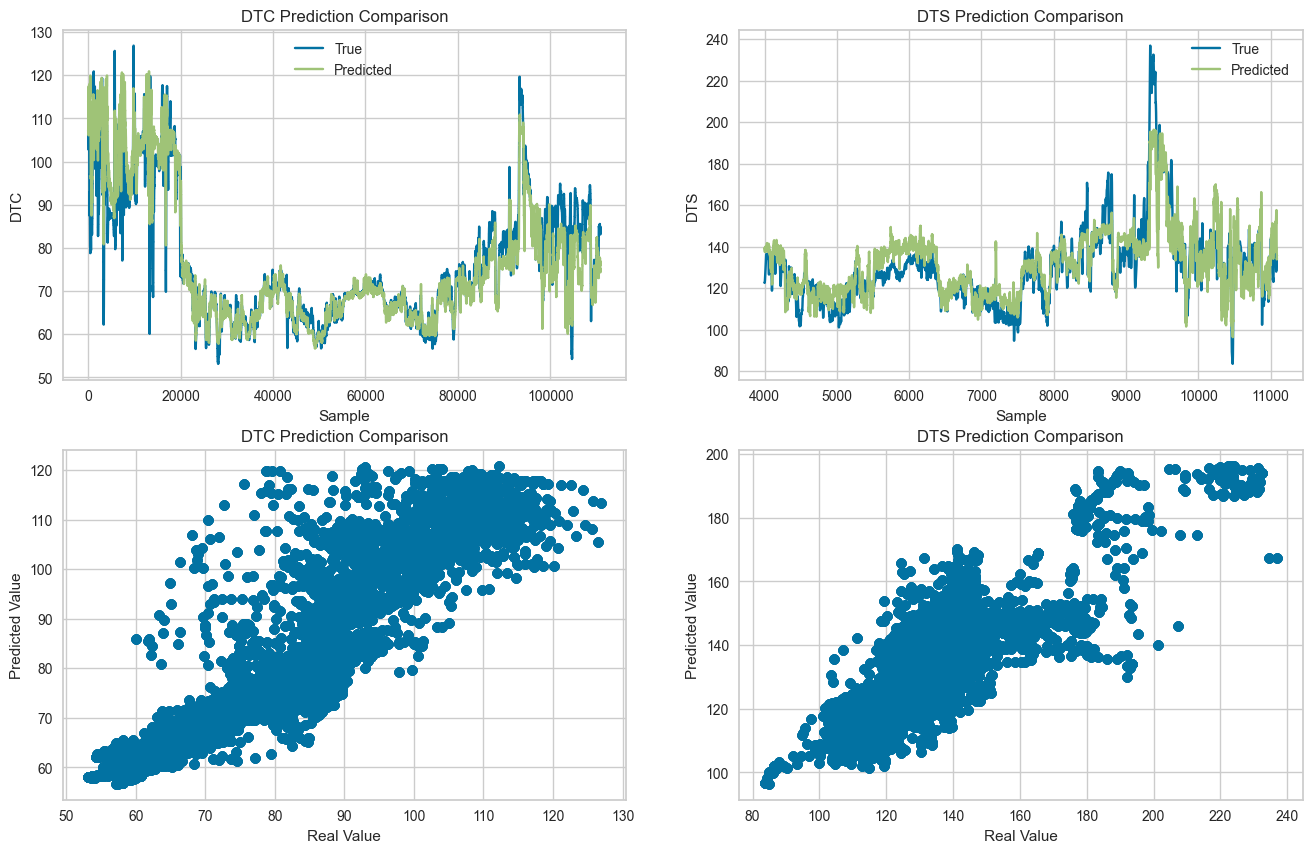

In [232]:
# check the accuracy of predicted data and plot the result
#print('Combined r2 score is:', '{:.5f}'.format((r2_score(y_real, y_predict))))
dtc_real = reals_wave[:, 0]
dtc_pred = preds_wave[:, 0]
dts_real = testing_data_cal['DTS  ']
dts_pred = final_test_df_dts_cal['DTS']
print('DTC:', '{:.5f}'.format(np.sqrt(r2_score(dtc_real, dtc_pred))))
print('DTS:', '{:.5f}'.format(np.sqrt(r2_score(dts_real, dts_pred))))
plt.subplots(nrows=2, ncols=2, figsize=(16,10))
plt.subplot(2, 2, 1)
plt.plot(reals_wave[:, 0])
plt.plot(preds_wave[:, 0])
plt.legend(['True', 'Predicted'])
plt.xlabel('Sample')
plt.ylabel('DTC')
plt.title('DTC Prediction Comparison')
    
plt.subplot(2, 2, 2)
plt.plot(testing_data_cal['DTS  '])
plt.plot(final_test_df_dts_cal['DTS'])
plt.legend(['True', 'Predicted'])
plt.xlabel('Sample')
plt.ylabel('DTS')
plt.title('DTS Prediction Comparison')
    
plt.subplot(2, 2, 3)
plt.scatter(reals_wave[:, 0], preds_wave[:, 0])
plt.xlabel('Real Value')
plt.ylabel('Predicted Value')
plt.title('DTC Prediction Comparison')
    
plt.subplot(2, 2, 4)
plt.scatter(testing_data_cal['DTS  '], final_test_df_dts_cal['DTS'])
plt.xlabel('Real Value')
plt.ylabel('Predicted Value')
plt.title('DTS Prediction Comparison')

plt.show()

RMSE of test data (#1 DTC): 5.38
RMSE of test data (#2 DTS): 10.35
Overall RMSE = 8.25


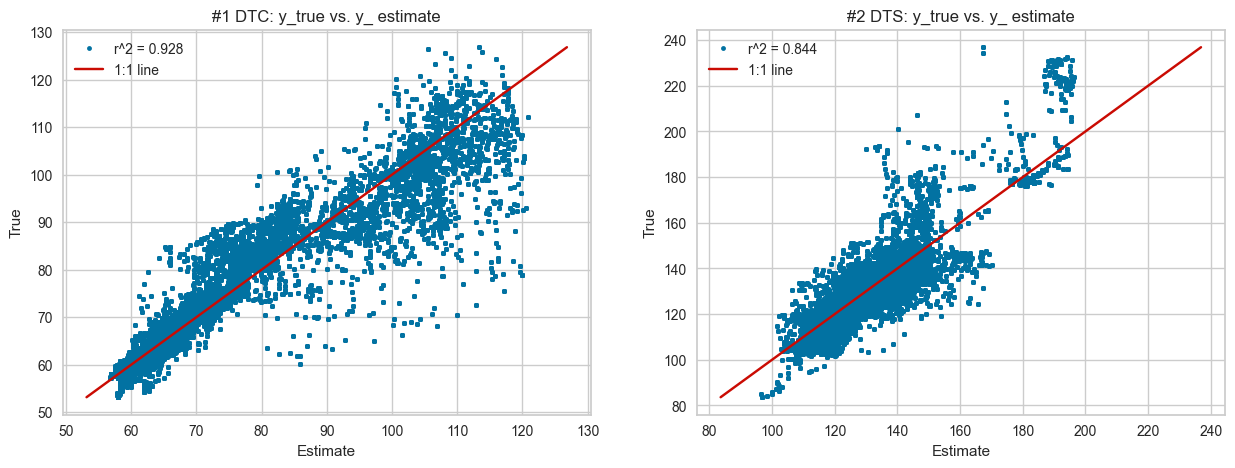

In [234]:
# Plot results:
plt.figure(figsize=(15,5))
i = 0
plt.subplot(1,2,i+1)
plt.plot(preds_wave[:,i], reals_wave[:,i], '.', label = 'r^2 = %.3f' % (np.sqrt(r2_score(reals_wave[:,i], preds_wave[:,i]))))
plt.plot([reals_wave[:,i].min(),reals_wave[:,i].max()],[reals_wave[:,i].min(),reals_wave[:,i].max()], 'r', label = '1:1 line')
plt.title('#1 DTC: y_true vs. y_ estimate'); plt.xlabel('Estimate'); plt.ylabel('True')
plt.legend()
i += 1
plt.subplot(1,2,i+1)
plt.plot(final_test_df_dts_cal['DTS'], testing_data_cal['DTS  '], '.', label = 'r^2 = %.3f' % np.sqrt((r2_score(testing_data_cal['DTS  '], final_test_df_dts_cal['DTS']))))
plt.plot([testing_data_cal['DTS  '].min(),testing_data_cal['DTS  '].max()],[testing_data_cal['DTS  '].min(),testing_data_cal['DTS  '].max()], 'r', label = '1:1 line')
plt.title('#2 DTS: y_true vs. y_ estimate'); plt.xlabel('Estimate'); plt.ylabel('True')
plt.legend()

MSE_0 = mean_squared_error(reals_wave[:,0], preds_wave[:,0]);
RMSE_0 = np.sqrt(mean_squared_error(reals_wave[:,0], preds_wave[:,0]));
MSE_1 = mean_squared_error(testing_data_cal['DTS  '], final_test_df_dts_cal['DTS']);
RMSE_1 = np.sqrt(mean_squared_error(testing_data_cal['DTS  '], final_test_df_dts_cal['DTS']));
print('RMSE of test data (#1 DTC): %.2f' %(RMSE_0))
print('RMSE of test data (#2 DTS): %.2f' %(RMSE_1))
print('Overall RMSE = %.2f' %np.sqrt((MSE_0+MSE_1)/2))

In [236]:
meandtc= np.sqrt(r2_score(dtc_real, dtc_pred))
meandts= np.sqrt(r2_score(dts_real, dts_pred))             
test_list= [meandtc,meandts]
sum = 0
for ele in test_list:
  sum += ele
res = sum / len(test_list)

In [238]:
print("Combined r2 after wavelet transformation is :",res)

Combined r2 after wavelet transformation is : 0.8860771547218939
